In [1]:
# Setup e imports
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../..')))

from scrappers.understat import Understat
from viz.shot_xg import plot_shot_xg
from blog.get_match_ids import get_match_ids
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

OUTPUT_DIR = "data/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print('Setup complete')

Setup complete


In [20]:
# Configuración
TEAM_NAME = "Barcelona"
LEAGUE = "ESP-La Liga"
SEASON = "25-26"
NUM_MATCHES = 14

# Jugadores
PLAYER_1_NAME = "Lewandowski"
PLAYER_1_LOGO = "../caras/extras/Lewandoski.png"

PLAYER_2_NAME = "Ferrán"
PLAYER_2_LOGO = "../caras/españa/Ferran.png"

print(f'Team: {TEAM_NAME}')
print(f'League: {LEAGUE}')
print(f'Season: {SEASON}')
print(f'Matches: {NUM_MATCHES}')
print(f'Players: {PLAYER_1_NAME} + {PLAYER_2_NAME}')

Team: Barcelona
League: ESP-La Liga
Season: 25-26
Matches: 14
Players: Lewandowski + Ferrán


In [3]:
# Extraer match IDs
print(f'Extrayendo IDs para {TEAM_NAME} - {LEAGUE} {SEASON}')
print('=' * 70)

all_matches = get_match_ids(TEAM_NAME, LEAGUE, SEASON, verbose=True)

matches = all_matches.head(NUM_MATCHES)
print(f'\nPrimeros {len(matches)} partidos:')
print(matches[['date', 'home_team', 'away_team', 'understat_id']])

understat_ids = matches['understat_id'].dropna().astype(int).tolist()
print(f'\n✓ Understat IDs disponibles: {len(understat_ids)}/{len(matches)}')

Extrayendo IDs para Barcelona - ESP-La Liga 25-26

Extrayendo IDs de partidos para:
  Equipo: Barcelona
  Liga: ESP-La Liga
  Temporada: 25-26

Extrayendo de WhoScored...


INFO     Retrieving calendar for ESP-La Liga 2526

INFO     [1/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [2/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [3/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [4/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [5/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [6/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [7/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [8/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [9/10] Retrieving fixtures for ESP-La Liga 2526

INFO     [10/10] Retrieving fixtures for ESP-La Liga 2526

   ✓ Encontrados 38 partidos en WhoScored

Extrayendo de Understat...
   ✓ Encontrados 38 partidos en Understat

RESUMEN:
   Total partidos encontrados: 56
   - Con ID WhoScored: 38
   - Con ID Understat: 38
   - Con ambos IDs: 20


Primeros 14 partidos:
                  date       home_team         away_team  understat_id
0  2025-08-16 17:30:00        Mallorca         Barcelona         29160
1  2025-08-23 19:30:00         Levante         Barcelona         29171
2  2025-08-31 19:30:00  Rayo Vallecano         Barcelona         29188
3  2025-09-14 19:00:00       Barcelona          Valencia         29194
4  2025-09-21 19:00:00       Barcelona            Getafe         29199
5  2025-09-25 19:30:00     Real Oviedo         Barcelona         29213
6  2025-09-28 16:30:00       Barcelona     Real Sociedad         29220
7  2025-10-05 14:15:00         Sevilla         Barcelona         29233
8  2025-10-18 14:15:00       Barcelona            Girona         29240
9  2025-10-26 15:15:00     Real Mad

In [13]:
def transform_understat_to_shotmap(df):
    df_transformed = df.copy()
    df_transformed['x'] = df_transformed['location_x'] * 100
    df_transformed['y'] = df_transformed['location_y'] * 100
    df_transformed['is_goal'] = df_transformed['result'] == 'Goal'
    df_transformed['shot_body_part'] = df_transformed['body_part'].apply(
        lambda x: 'Head' if pd.isna(x) or x == 'Other' else x
    )
    return df_transformed

print('Helper function defined')

Helper function defined


In [14]:
# Extraer datos de disparos
us = Understat(leagues=LEAGUE, seasons='2025')

player1_shots = []
player2_shots = []

print('Extrayendo datos de Understat...')
print('=' * 70)

for i, (idx, row) in enumerate(matches.iterrows(), 1):
    match_id = row['understat_id']

    if pd.isna(match_id):
        print(f'[{i}/{len(matches)}] Sin ID Understat')
        continue

    try:
        shots = us.read_shot_events(match_id=int(match_id))
        shots_reset = shots.reset_index()

        # Filtrar shots de Player 1
        p1_shots = shots_reset[
            shots_reset['player'].str.contains(PLAYER_1_NAME, case=False, na=False)
        ].copy()
        
        # Filtrar shots de Player 2
        p2_shots = shots_reset[
            shots_reset['player'].str.contains(PLAYER_2_NAME, case=False, na=False)
        ].copy()

        if not p1_shots.empty:
            player1_shots.append(p1_shots)
        
        if not p2_shots.empty:
            player2_shots.append(p2_shots)
        
        p1_count = len(p1_shots)
        p2_count = len(p2_shots)
        print(f'[{i}/{len(matches)}] Match {int(match_id)}: {PLAYER_1_NAME}: {p1_count} shots | {PLAYER_2_NAME}: {p2_count} shots')

    except Exception as e:
        print(f'[{i}/{len(matches)}] Match {int(match_id)}: ERROR - {e}')

# Consolidar
if player1_shots:
    df_player1 = pd.concat(player1_shots, ignore_index=True)
    print('\n' + '=' * 70)
    print(f'{PLAYER_1_NAME}: {len(df_player1)} shots | {(df_player1["result"] == "Goal").sum()} goals | {df_player1["xg"].sum():.2f} xG')
else:
    df_player1 = pd.DataFrame()
    print(f'\n⚠ No se encontraron disparos de {PLAYER_1_NAME}')

if player2_shots:
    df_player2 = pd.concat(player2_shots, ignore_index=True)
    print(f'{PLAYER_2_NAME}: {len(df_player2)} shots | {(df_player2["result"] == "Goal").sum()} goals | {df_player2["xg"].sum():.2f} xG')
else:
    df_player2 = pd.DataFrame()
    print(f'⚠ No se encontraron disparos de {PLAYER_2_NAME}')

Extrayendo datos de Understat...


[1/14] Match 29160: Lewandowski: 0 shots | Ferrán: 3 shots
[2/14] Match 29171: Lewandowski: 0 shots | Ferrán: 5 shots
[3/14] Match 29188: Lewandowski: 0 shots | Ferrán: 0 shots
[4/14] Match 29194: Lewandowski: 2 shots | Ferrán: 5 shots
[5/14] Match 29199: Lewandowski: 2 shots | Ferrán: 4 shots
[6/14] Match 29213: Lewandowski: 2 shots | Ferrán: 6 shots
[7/14] Match 29220: Lewandowski: 5 shots | Ferrán: 0 shots
[8/14] Match 29233: Lewandowski: 4 shots | Ferrán: 0 shots
[9/14] Match 29240: Lewandowski: 0 shots | Ferrán: 0 shots
[10/14] Match 29254: Lewandowski: 0 shots | Ferrán: 2 shots
[11/14] Match 29260: Lewandowski: 1 shots | Ferrán: 3 shots
[12/14] Match 29274: Lewandowski: 6 shots | Ferrán: 1 shots
[13/14] Match 29284: Lewandowski: 3 shots | Ferrán: 3 shots
[14/14] Match 29294: Lewandowski: 2 shots | Ferrán: 0 shots

Lewandowski: 27 shots | 8 goals | 7.20 xG
Ferrán: 32 shots | 7 goals | 6.43 xG


In [15]:
# Transformar y guardar Player 1
if not df_player1.empty:
    df_player1_shotmap = transform_understat_to_shotmap(df_player1)
    csv_path_p1 = f'{OUTPUT_DIR}{PLAYER_1_NAME.lower()}_shots.csv'
    df_player1_shotmap.to_csv(csv_path_p1, index=False)
    print(f'Guardado: {csv_path_p1}')

# Transformar y guardar Player 2
if not df_player2.empty:
    df_player2_shotmap = transform_understat_to_shotmap(df_player2)
    csv_path_p2 = f'{OUTPUT_DIR}{PLAYER_2_NAME.lower()}_shots.csv'
    df_player2_shotmap.to_csv(csv_path_p2, index=False)
    print(f'Guardado: {csv_path_p2}')

Guardado: data/lewandowski_shots.csv
Guardado: data/ferrán_shots.csv


In [16]:
# Estadísticas Player 1
if not df_player1.empty:
    shots_count = len(df_player1)
    goals = (df_player1['result'] == 'Goal').sum()
    xg_total = df_player1['xg'].sum()
    performance = goals - xg_total

    print('=' * 70)
    print(f'{PLAYER_1_NAME.upper()} - SHOT ANALYSIS')
    print(f'{TEAM_NAME} | {LEAGUE} {SEASON}')
    print('=' * 70)
    print(f'Partidos analizados: {len(matches)}')
    print(f'Total shots: {shots_count}')
    print(f'Goles: {goals}')
    print(f'xG total: {xg_total:.2f}')
    print(f'Performance vs xG: {performance:+.2f} ({performance/xg_total*100:+.1f}%)')
    print(f'Conversión: {goals/shots_count*100:.1f}%')

LEWANDOWSKI - SHOT ANALYSIS
Barcelona | ESP-La Liga 25-26
Partidos analizados: 14
Total shots: 27
Goles: 8
xG total: 7.20
Performance vs xG: +0.80 (+11.2%)
Conversión: 29.6%


In [17]:
# Estadísticas Player 2
if not df_player2.empty:
    shots_count = len(df_player2)
    goals = (df_player2['result'] == 'Goal').sum()
    xg_total = df_player2['xg'].sum()
    performance = goals - xg_total

    print('=' * 70)
    print(f'{PLAYER_2_NAME.upper()} - SHOT ANALYSIS')
    print(f'{TEAM_NAME} | {LEAGUE} {SEASON}')
    print('=' * 70)
    print(f'Partidos analizados: {len(matches)}')
    print(f'Total shots: {shots_count}')
    print(f'Goles: {goals}')
    print(f'xG total: {xg_total:.2f}')
    print(f'Performance vs xG: {performance:+.2f} ({performance/xg_total*100:+.1f}%)')
    print(f'Conversión: {goals/shots_count*100:.1f}%')

FERRÁN - SHOT ANALYSIS
Barcelona | ESP-La Liga 25-26
Partidos analizados: 14
Total shots: 32
Goles: 7
xG total: 6.43
Performance vs xG: +0.57 (+8.9%)
Conversión: 21.9%


Saved: data/lewandowski_shots.png


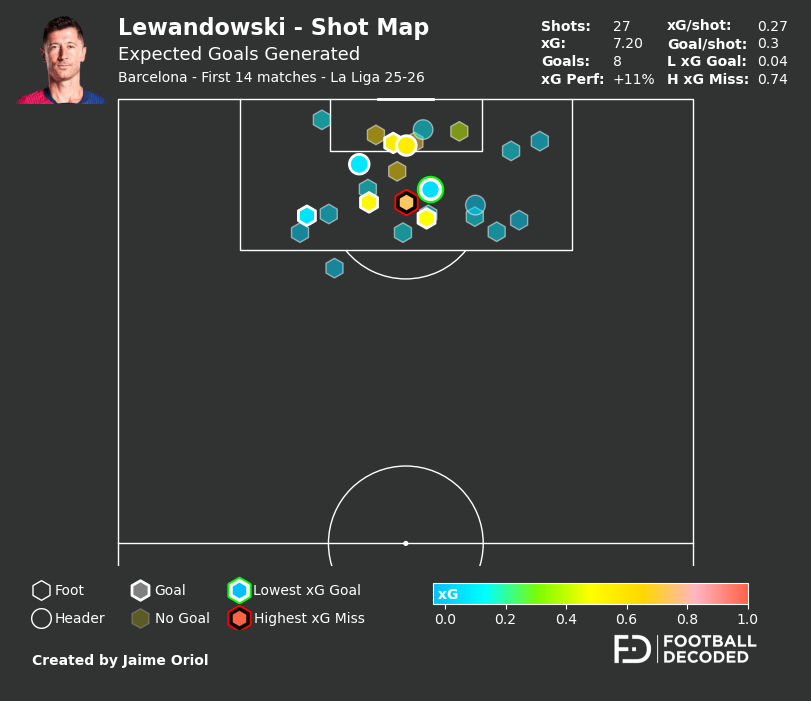

In [21]:
# Generar visualización Player 1
if not df_player1.empty:
    fig_p1 = plot_shot_xg(
        csv_path=csv_path_p1,
        filter_by='all',
        logo_path=PLAYER_1_LOGO,
        title_text=f'{PLAYER_1_NAME} - Shot Map',
        subtitle_text='Expected Goals Generated',
        subsubtitle_text=f'{TEAM_NAME} - First {NUM_MATCHES} matches - La Liga {SEASON}'
    )

    png_path_p1 = f'{OUTPUT_DIR}{PLAYER_1_NAME.lower()}_shots.png'
    fig_p1.savefig(png_path_p1, dpi=300, bbox_inches='tight', facecolor='#313332')
    print(f'Saved: {png_path_p1}')

Saved: data/ferrán_shots.png


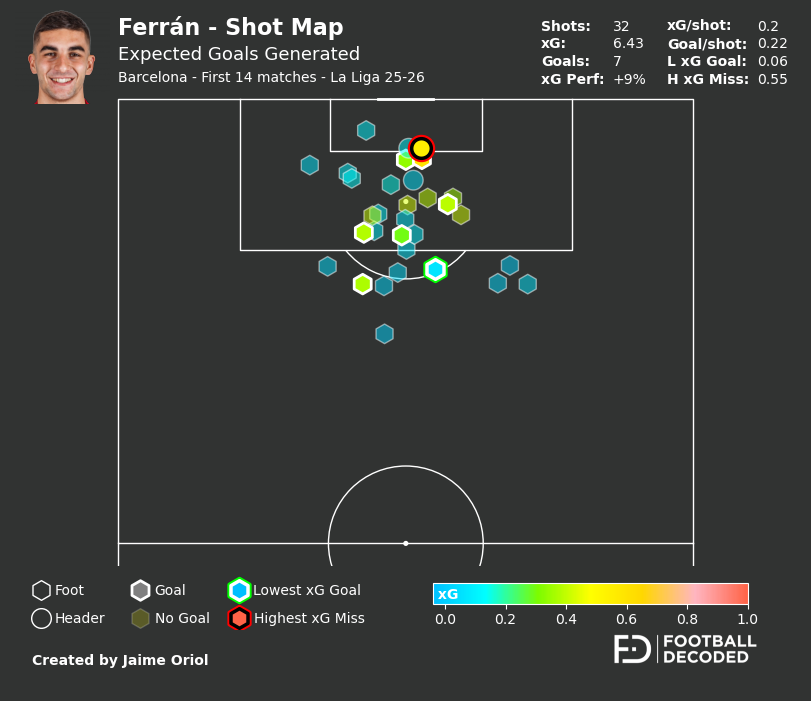

In [19]:
# Generar visualización Player 2
if not df_player2.empty:
    fig_p2 = plot_shot_xg(
        csv_path=csv_path_p2,
        filter_by='all',
        logo_path=PLAYER_2_LOGO,
        title_text=f'{PLAYER_2_NAME} - Shot Map',
        subtitle_text='Expected Goals Generated',
        subsubtitle_text=f'{TEAM_NAME} - First {NUM_MATCHES} matches - La Liga {SEASON}'
    )

    png_path_p2 = f'{OUTPUT_DIR}{PLAYER_2_NAME.lower()}_shots.png'
    fig_p2.savefig(png_path_p2, dpi=300, bbox_inches='tight', facecolor='#313332')
    print(f'Saved: {png_path_p2}')

In [11]:
# Resumen de archivos
print('=' * 70)
print('ARCHIVOS GENERADOS:')
print('=' * 70)

if not df_player1.empty:
    print(f'\n{PLAYER_1_NAME}:')
    print(f'  {csv_path_p1}')
    print(f'  {png_path_p1}')

if not df_player2.empty:
    print(f'\n{PLAYER_2_NAME}:')
    print(f'  {csv_path_p2}')
    print(f'  {png_path_p2}')

ARCHIVOS GENERADOS:

Lewandowski:
  data/lewandowski_shots.csv
  data/lewandowski_shots.png
